In [1]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from matplotlib import font_manager
from matplotlib import rc
from pyhive import hive
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import trange
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import tensorflow as tf

Using TensorFlow backend.


In [2]:
%matplotlib inline
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
    rc('font', family=font_name)
else:
    print('운영체제 정보를 불러올 수 없습니다. 폰트 설정에 실패하였습니다.')

In [3]:
cnx = hive.Connection(
    host='hd02.pdmnu.com'
    , username='sweetbarrow'
    , database='mlens'
    , auth='NOSASL'
)
cnx

In [4]:
ratings_rescaled = pd.read_sql('SELECT * FROM mlens.ratings_rescaled', cnx)
ratings_rescaled.rename(
    columns={
        'ratings_rescaled.user_id': 'user_id'
        , 'ratings_rescaled.movie_id': 'movie_id'
        , 'ratings_rescaled.rating_rescaled': 'rating'
    }
    , inplace=True
)
ratings_rescaled

,user_id,movie_id,rating
0,1,307,1
1,1,481,1
2,1,1091,-1
3,1,1257,1
4,1,1449,1
...,...,...,...
27753439,283228,8542,1
27753440,283228,8712,1
27753441,283228,34405,1
27753442,283228,44761,1


In [5]:
ratings_genres = pd.read_sql('SELECT * FROM mlens.ratings_genres', cnx)
ratings_genres.rename(
    columns={
        'ratings_genres.user_id': 'user_id'
        , 'ratings_genres.action': 'action'
        , 'ratings_genres.adventure': 'adventure'
        , 'ratings_genres.animation': 'animation'
        , 'ratings_genres.children': 'children'
        , 'ratings_genres.comedy': 'comedy'
        , 'ratings_genres.crime': 'crime'
        , 'ratings_genres.documentary': 'documentary'
        , 'ratings_genres.drama': 'drama'
        , 'ratings_genres.fantasy': 'fantasy'
        , 'ratings_genres.film_noir': 'film_noir'
        , 'ratings_genres.horror': 'horror'
        , 'ratings_genres.imax': 'imax'
        , 'ratings_genres.musical': 'musical'
        , 'ratings_genres.mystery': 'mystery'
        , 'ratings_genres.romance': 'romance'
        , 'ratings_genres.sci_fi': 'sci_fi'
        , 'ratings_genres.thriller': 'thriller'
        , 'ratings_genres.war': 'war'
        , 'ratings_genres.western': 'western'
    }
    , inplace=True
)
ratings_genres

,user_id,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,imax,musical,mystery,romance,sci_fi,thriller,war,western
0,1,0,-1,0,0,4,0,0,5,1,0,-2,0,0,0,2,-2,-2,0,1
1,2,2,2,0,0,6,1,0,6,0,0,1,0,1,0,3,1,3,0,0
2,3,1,1,0,1,1,1,0,4,0,0,0,0,0,1,0,0,2,1,0
3,4,192,104,17,-4,27,88,4,137,39,3,22,6,-3,31,26,78,167,25,0
4,5,13,7,0,0,17,31,2,48,2,2,0,1,0,11,8,3,24,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283223,283224,37,33,2,7,43,30,1,99,12,6,13,0,14,16,31,28,44,20,11
283224,283225,-3,-2,0,0,0,4,0,-1,0,1,0,0,-1,1,-1,-1,-1,-1,1
283225,283226,-6,-3,0,-1,-3,-2,0,-3,0,0,-1,0,0,-1,-1,-2,-4,0,0
283226,283227,2,0,0,3,4,2,0,6,0,0,0,0,0,0,2,0,3,0,1


In [6]:
ratings_merged = ratings_rescaled.merge(
    ratings_genres
    , how='left'
    , left_on='user_id'
    , right_on='user_id'
    , left_index=False
    , right_index=False
    , suffixes=('_resc', '_genres')
)
ratings_merged

,user_id,movie_id,rating,action,adventure,animation,children,comedy,crime,documentary,...,film_noir,horror,imax,musical,mystery,romance,sci_fi,thriller,war,western
0,1,307,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
1,1,481,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
2,1,1091,-1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
3,1,1257,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
4,1,1449,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27753439,283228,8542,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6
27753440,283228,8712,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6
27753441,283228,34405,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6
27753442,283228,44761,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6


In [7]:
ratings_refined = ratings_merged.drop(ratings_merged[ratings_merged['rating'] < 0].index, axis=0)
ratings_refined

,user_id,movie_id,rating,action,adventure,animation,children,comedy,crime,documentary,...,film_noir,horror,imax,musical,mystery,romance,sci_fi,thriller,war,western
0,1,307,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
1,1,481,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
3,1,1257,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
4,1,1449,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
7,1,2134,1,0,-1,0,0,4,0,0,...,0,-2,0,0,0,2,-2,-2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27753439,283228,8542,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6
27753440,283228,8712,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6
27753441,283228,34405,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6
27753442,283228,44761,1,25,18,4,5,43,24,0,...,9,6,0,4,23,31,10,34,8,6


In [8]:
movies = pd.read_sql('SELECT * FROM mlens.movies', cnx)
movies.drop('movies.title', axis=1, inplace=True)
movies.rename(
    columns={
        'movies.movieid': 'movie_id'
        , 'movies.genres': 'genres'
    }
    , inplace=True
)
movies

,movie_id,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy
...,...,...
58093,175409,Comedy|Drama
58094,175411,Animation
58095,175413,Comedy|Romance
58096,175415,Drama|Romance


In [9]:
genres_splitted = movies['genres'].str.split('|')
genres_splitted

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
58093                                      [Comedy, Drama]
58094                                          [Animation]
58095                                    [Comedy, Romance]
58096                                     [Drama, Romance]
58097                                    [Comedy, Romance]
Name: genres, Length: 58098, dtype: object

In [10]:
movies = movies.merge(genres_splitted, left_index=True, right_index=True)
movies

,movie_id,genres_x,genres_y
0,1,Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Comedy|Romance,"[Comedy, Romance]"
3,4,Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Comedy,[Comedy]
...,...,...,...
58093,175409,Comedy|Drama,"[Comedy, Drama]"
58094,175411,Animation,[Animation]
58095,175413,Comedy|Romance,"[Comedy, Romance]"
58096,175415,Drama|Romance,"[Drama, Romance]"


In [11]:
genres = pd.read_sql('SELECT * FROM mlens.genres', cnx)
genres.rename(
    columns={
        'genres.genre_id': 'genre_id'
        , 'genres.genre_name': 'genre_name'
    }
    , inplace=True
)
genres

,genre_id,genre_name
0,0,NULL
1,1,Action
2,2,Adventure
3,3,Animation
4,4,Children
5,5,Comedy
6,6,Crime
7,7,Documentary
8,8,Drama
9,9,Fantasy


In [12]:
genres_dict = genres.to_dict(orient='records')
genres_dict

[{'genre_id': 0, 'genre_name': 'NULL'},
 {'genre_id': 1, 'genre_name': 'Action'},
 {'genre_id': 2, 'genre_name': 'Adventure'},
 {'genre_id': 3, 'genre_name': 'Animation'},
 {'genre_id': 4, 'genre_name': 'Children'},
 {'genre_id': 5, 'genre_name': 'Comedy'},
 {'genre_id': 6, 'genre_name': 'Crime'},
 {'genre_id': 7, 'genre_name': 'Documentary'},
 {'genre_id': 8, 'genre_name': 'Drama'},
 {'genre_id': 9, 'genre_name': 'Fantasy'},
 {'genre_id': 10, 'genre_name': 'Film-Noir'},
 {'genre_id': 11, 'genre_name': 'Horror'},
 {'genre_id': 12, 'genre_name': 'IMAX'},
 {'genre_id': 13, 'genre_name': 'Musical'},
 {'genre_id': 14, 'genre_name': 'Mystery'},
 {'genre_id': 15, 'genre_name': 'Romance'},
 {'genre_id': 16, 'genre_name': 'Sci-Fi'},
 {'genre_id': 17, 'genre_name': 'Thriller'},
 {'genre_id': 18, 'genre_name': 'War'},
 {'genre_id': 19, 'genre_name': 'Western'}]

In [13]:
genres_dict_new = {}
for _ in genres_dict:
    id_value = _['genre_id']
    genre_value = _['genre_name']
    genres_dict_new[genre_value] = id_value
genres_dict_new['(no genres listed)'] = 0
genres_dict_new

{'NULL': 0,
 'Action': 1,
 'Adventure': 2,
 'Animation': 3,
 'Children': 4,
 'Comedy': 5,
 'Crime': 6,
 'Documentary': 7,
 'Drama': 8,
 'Fantasy': 9,
 'Film-Noir': 10,
 'Horror': 11,
 'IMAX': 12,
 'Musical': 13,
 'Mystery': 14,
 'Romance': 15,
 'Sci-Fi': 16,
 'Thriller': 17,
 'War': 18,
 'Western': 19,
 '(no genres listed)': 0}

In [14]:
for index in trange(len(movies)):
    genres_data = movies.loc[index, 'genres_y']
    for genre in genres_data:
        list_index = genres_data.index(genre)
        genres_data[list_index] = genres_dict_new[genre]
    genres_list = np.array(genres_data)
    movies.at[index, 'genres_y'] = genres_list
movies.rename(columns={'genres_y': 'genres'}, inplace=True)
movies.drop(['genres_x'], axis=1, inplace=True)
movies

100%|█████████████████████████████████████████████████████████████████████████| 58098/58098 [00:00<00:00, 78136.29it/s]


,movie_id,genres
0,1,"[2, 3, 4, 5, 9]"
1,2,"[2, 4, 9]"
2,3,"[5, 15]"
3,4,"[5, 8, 15]"
4,5,[5]
...,...,...
58093,175409,"[5, 8]"
58094,175411,[3]
58095,175413,"[5, 15]"
58096,175415,"[8, 15]"


In [15]:
ratings_new = ratings_refined.merge(movies, left_on='movie_id', right_on='movie_id')
ratings_new

,user_id,movie_id,rating,action,adventure,animation,children,comedy,crime,documentary,...,horror,imax,musical,mystery,romance,sci_fi,thriller,war,western,genres
0,1,307,1,0,-1,0,0,4,0,0,...,-2,0,0,0,2,-2,-2,0,1,[8]
1,6,307,1,0,3,1,1,6,7,0,...,1,1,1,3,5,1,8,2,1,[8]
2,56,307,1,-30,-42,-11,-40,-107,10,5,...,-11,-5,-12,29,-22,9,-1,12,7,[8]
3,71,307,1,24,25,24,8,21,28,2,...,2,3,5,21,17,23,29,13,1,[8]
4,84,307,0,3,2,0,2,12,7,0,...,0,0,-1,2,15,1,4,4,1,[8]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22759418,282732,161572,1,89,96,42,37,84,57,2,...,52,12,19,48,49,54,83,29,16,[8]
22759419,282808,193373,1,56,36,-5,2,17,32,60,...,-13,2,0,-7,-19,33,30,7,1,[7]
22759420,283000,117857,1,155,180,151,120,598,128,97,...,22,35,140,68,326,116,139,48,28,[7]
22759421,283000,133409,1,155,180,151,120,598,128,97,...,22,35,140,68,326,116,139,48,28,[0]


In [16]:
x = ratings_new.loc[:, 'action':'western']
x

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,imax,musical,mystery,romance,sci_fi,thriller,war,western
0,0,-1,0,0,4,0,0,5,1,0,-2,0,0,0,2,-2,-2,0,1
1,0,3,1,1,6,7,0,11,0,0,1,1,1,3,5,1,8,2,1
2,-30,-42,-11,-40,-107,10,5,63,-14,1,-11,-5,-12,29,-22,9,-1,12,7
3,24,25,24,8,21,28,2,84,29,3,2,3,5,21,17,23,29,13,1
4,3,2,0,2,12,7,0,74,0,0,0,0,-1,2,15,1,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22759418,89,96,42,37,84,57,2,163,63,11,52,12,19,48,49,54,83,29,16
22759419,56,36,-5,2,17,32,60,22,5,0,-13,2,0,-7,-19,33,30,7,1
22759420,155,180,151,120,598,128,97,772,108,17,22,35,140,68,326,116,139,48,28
22759421,155,180,151,120,598,128,97,772,108,17,22,35,140,68,326,116,139,48,28


In [17]:
y = ratings_new.loc[:, 'genres']
y

0           [8]
1           [8]
2           [8]
3           [8]
4           [8]
           ... 
22759418    [8]
22759419    [7]
22759420    [7]
22759421    [0]
22759422    [7]
Name: genres, Length: 22759423, dtype: object

In [18]:
multi_labeling = preprocessing.MultiLabelBinarizer()
y_label = multi_labeling.fit_transform(y)
y_label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y_label, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(17069567, 19) (5689856, 19) (17069567, 20) (5689856, 20)


In [20]:
model_sgd = Sequential()

model_sgd.add(Dense(5000, activation='relu', input_dim=x_train.shape[1]))
model_sgd.add(Dropout(0.1))
model_sgd.add(Dense(600, activation='relu'))
model_sgd.add(Dropout(0.1))
model_sgd.add(Dense(y_train.shape[1], activation='sigmoid'))

sgd_ = SGD(
    lr=0.01
    , momentum=0.9
    , decay=1e-6
    , nesterov=True
)

model_sgd.compile(
    optimizer=sgd_
    , loss='binary_crossentropy'
    , metrics=['accuracy']
)

history_sgd = model_sgd.fit(
    x=x_train
    , y=y_train
    , batch_size=5000
    , epochs=10
    , verbose=1
    , validation_data=(x_test, y_test)
    , workers=80
    , use_multiprocessing=True
)

preds_sgd = model_sgd.predict(x_test)
preds_sgd[preds_sgd >= 0.5] = 1
preds_sgd[preds_sgd < 0.5] = 0

Train on 17069567 samples, validate on 5689856 samples
Epoch 1/10
17069567/17069567 [==============================] - 103s 6us/step - loss: 0.3468 - accuracy: 0.8663 - val_loss: 0.3234 - val_accuracy: 0.8675
Epoch 2/10
17069567/17069567 [==============================] - 102s 6us/step - loss: 0.3234 - accuracy: 0.8674 - val_loss: 0.3210 - val_accuracy: 0.8678
Epoch 3/10
17069567/17069567 [==============================] - 103s 6us/step - loss: 0.3211 - accuracy: 0.8677 - val_loss: 0.3195 - val_accuracy: 0.8680
Epoch 4/10
17069567/17069567 [==============================] - 103s 6us/step - loss: 0.3200 - accuracy: 0.8679 - val_loss: 0.3187 - val_accuracy: 0.8682
Epoch 5/10
17069567/17069567 [==============================] - 104s 6us/step - loss: 0.3193 - accuracy: 0.8681 - val_loss: 0.3180 - val_accuracy: 0.8683
Epoch 6/10
17069567/17069567 [==============================] - 104s 6us/step - loss: 0.3188 - accuracy: 0.8682 - val_loss: 0.3178 - val_accuracy: 0.8683
Epoch 7/10
17069567/1

In [21]:
model_adam = Sequential()

model_adam.add(Dense(5000, activation='relu', input_dim=x_train.shape[1]))
model_adam.add(Dropout(0.1))
model_adam.add(Dense(600, activation='relu'))
model_adam.add(Dropout(0.1))
model_adam.add(Dense(y_train.shape[1], activation='sigmoid'))

model_adam.compile(
    optimizer='adam'
    , loss='binary_crossentropy'
    , metrics=['accuracy']
)

history_adam = model_adam.fit(
    x=x_train
    , y=y_train
    , batch_size=5000
    , epochs=10
    , verbose=1
    , validation_data=(x_test, y_test)
    , workers=80
    , use_multiprocessing=True
)

preds_adam = model_adam.predict(x_test)
preds_adam[preds_adam >= 0.5] = 1
preds_adam[preds_adam < 0.5] = 0

Train on 17069567 samples, validate on 5689856 samples
Epoch 1/10
17069567/17069567 [==============================] - 107s 6us/step - loss: 0.3294 - accuracy: 0.8672 - val_loss: 0.3163 - val_accuracy: 0.8685
Epoch 2/10
17069567/17069567 [==============================] - 106s 6us/step - loss: 0.3172 - accuracy: 0.8684 - val_loss: 0.3159 - val_accuracy: 0.8686
Epoch 3/10
17069567/17069567 [==============================] - 106s 6us/step - loss: 0.3167 - accuracy: 0.8684 - val_loss: 0.3157 - val_accuracy: 0.8686
Epoch 4/10
17069567/17069567 [==============================] - 108s 6us/step - loss: 0.3164 - accuracy: 0.8684 - val_loss: 0.3158 - val_accuracy: 0.8685
Epoch 5/10
17069567/17069567 [==============================] - 106s 6us/step - loss: 0.3162 - accuracy: 0.8684 - val_loss: 0.3157 - val_accuracy: 0.8686
Epoch 6/10
17069567/17069567 [==============================] - 107s 6us/step - loss: 0.3161 - accuracy: 0.8684 - val_loss: 0.3155 - val_accuracy: 0.8686
Epoch 7/10
17069567/1

In [22]:
model_nadam = Sequential()

model_nadam.add(Dense(5000, activation='relu', input_dim=x_train.shape[1]))
model_nadam.add(Dropout(0.1))
model_nadam.add(Dense(600, activation='relu'))
model_nadam.add(Dropout(0.1))
model_nadam.add(Dense(y_train.shape[1], activation='sigmoid'))

model_nadam.compile(
    optimizer='nadam'
    , loss='binary_crossentropy'
    , metrics=['accuracy']
)

history_nadam = model_nadam.fit(
    x=x_train
    , y=y_train
    , batch_size=5000
    , epochs=10
    , verbose=1
    , validation_data=(x_test, y_test)
    , workers=80
    , use_multiprocessing=True
)

preds_nadam = model_nadam.predict(x_test)
preds_nadam[preds_nadam >= 0.5] = 1
preds_nadam[preds_nadam < 0.5] = 0

Train on 17069567 samples, validate on 5689856 samples
Epoch 1/10
17069567/17069567 [==============================] - 112s 7us/step - loss: 0.3359 - accuracy: 0.8672 - val_loss: 0.3184 - val_accuracy: 0.8681
Epoch 2/10
17069567/17069567 [==============================] - 112s 7us/step - loss: 0.3172 - accuracy: 0.8683 - val_loss: 0.3160 - val_accuracy: 0.8685
Epoch 3/10
17069567/17069567 [==============================] - 113s 7us/step - loss: 0.3166 - accuracy: 0.8684 - val_loss: 0.3160 - val_accuracy: 0.8685
Epoch 4/10
17069567/17069567 [==============================] - 115s 7us/step - loss: 0.3165 - accuracy: 0.8683 - val_loss: 0.3159 - val_accuracy: 0.8685
Epoch 5/10
17069567/17069567 [==============================] - 117s 7us/step - loss: 0.3165 - accuracy: 0.8683 - val_loss: 0.3159 - val_accuracy: 0.8685
Epoch 6/10
17069567/17069567 [==============================] - 113s 7us/step - loss: 0.3165 - accuracy: 0.8683 - val_loss: 0.3159 - val_accuracy: 0.8685
Epoch 7/10
17069567/1

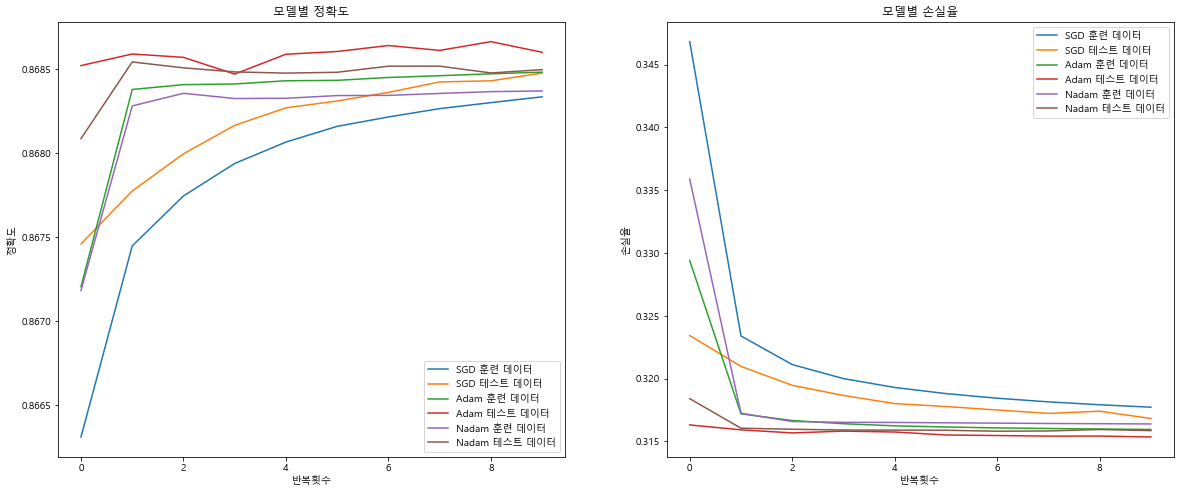

In [23]:
fig = plt.figure(figsize=(20, 8))
acc = fig.add_subplot(1, 2, 1)
loss = fig.add_subplot(1, 2, 2)

acc.plot(history_sgd.history['accuracy'])
acc.plot(history_sgd.history['val_accuracy'])
acc.plot(history_adam.history['accuracy'])
acc.plot(history_adam.history['val_accuracy'])
acc.plot(history_nadam.history['accuracy'])
acc.plot(history_nadam.history['val_accuracy'])
acc.set_title('모델별 정확도')
acc.set_xlabel('반복횟수')
acc.set_ylabel('정확도')
acc.legend(['SGD 훈련 데이터', 'SGD 테스트 데이터', 'Adam 훈련 데이터', 'Adam 테스트 데이터', 'Nadam 훈련 데이터', 'Nadam 테스트 데이터'], loc='best')

loss.plot(history_sgd.history['loss'])
loss.plot(history_sgd.history['val_loss'])
loss.plot(history_adam.history['loss'])
loss.plot(history_adam.history['val_loss'])
loss.plot(history_nadam.history['loss'])
loss.plot(history_nadam.history['val_loss'])
loss.set_title('모델별 손실율')
loss.set_xlabel('반복횟수')
loss.set_ylabel('손실율')
loss.legend(['SGD 훈련 데이터', 'SGD 테스트 데이터', 'Adam 훈련 데이터', 'Adam 테스트 데이터', 'Nadam 훈련 데이터', 'Nadam 테스트 데이터'], loc='best')

plt.show()

In [24]:
df_preds_sgd = pd.DataFrame(preds_sgd, columns=genres['genre_name'])
df_preds_sgd

genre_name,NULL,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_preds_adam = pd.DataFrame(preds_adam, columns=genres['genre_name'])
df_preds_adam

genre_name,NULL,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_preds_nadam = pd.DataFrame(preds_nadam, columns=genres['genre_name'])
df_preds_nadam

genre_name,NULL,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
